# 遗传算法在TSP中的应用

Author：周建山 BY1613123

Email：jianshanzhou@foxmail.com

Web：https://github.com/JianshanZhou/Computing-Intelligence-Course.git

本次报告主要给出遗传算法求解TSP问题的Python实现。
    
在对TSP问题的解进行遗传编码时，一种自然的编码方式可以通过城市ID号(引索号)构成的序列来完成。然而，这种编码存在缺陷：遗传算法常规的交叉和变异操作会使种群中产生一些不满足TSP问题约束条件或者没有实际意义的路线。为了避免这种缺陷，本报告采用由Grefenstette等人提出的、基于访问次序的编码规则来完成遗传编码——将TSP的解映射为适合遗传操作的染色体[[1]](#ref1)。基于Grefenstette等人提出的编码规则，得到任意基因型个体都能够对应于一条满足TSP问题约束的路径，尤其是，这种编码映射下，基因型个体经过常规的遗传操作后得到的新个体也能够满足TSP问题的约束，对应于一条具有实际意义的路径。因此，可以避免遗传算法在迭代过程中对不可行解的修正步骤。
    
+ **注意1**：本报告中，所采用的适应度函数为如下函数：
$$
\mathit{fitness}(O) = 2 - \mathit{sp} - 2(\mathit{sp}-1)\frac{O-1}{\mathit{Size}-1} 
$$
其中，$\mathit{sp}\in[1,2]$为遗传进化过程中的选择压力参数，本报告中设置为$\mathit{sp}=1.75$，$\mathit{Size}$表示种群规模，亦即基因型个体总数，$O$为基因型个体根据对应解的目标函数值(路径总长度)在整体种群中相对优劣排名，例如，由于在TSP问题中以最小化总路径长度为目标，在$\mathit{Size}$个基因型个体构成的种群中，具有最小总路径长度的基因型个体，其排名为$\mathit{Size}$，具有最大总路径长度的基因个体，其排名为1。例如，给定一个种群$\mathcal{I}$，如果记某一个基因型个体为$i$，$i\in\mathcal{I}$且$\vert\mathcal{I}\vert=\mathit{Size}$，它所对应的TSP解(路径)的目标函数值(总长度)为$\mathit{objective}_i$，如果有：
$$
\left\{
\mathit{objective}_{i_1}\leq\mathit{objective}_{i_2}\leq\ldots\leq
\mathit{objective}_{i_{\mathit{Size}}}
\right\}
$$
则
$$
O_{i_1}=\mathit{Size}>O_{i_2}=\mathit{Size}-1>\ldots>
O_{i_{\mathit{Size}}}=1
$$
+ **注意2**：遗传算法的交叉算子采用**单点交叉**规则实现，变异算子采用**交换变异**规则实现，选择算子采用**轮盘赌**规则实现。算法具体的实现详见如下代码程序。

In [5]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Copyright (C) Fri Dec 09 21:40:36 2016  Jianshan Zhou
Contact: zhoujianshan@buaa.edu.cn	jianshanzhou@foxmail.com
Website: <https://github.com/JianshanZhou>

This program is free software: you can redistribute
 it and/or modify it under the terms of
 the GNU General Public License as published
 by the Free Software Foundation,
 either version 3 of the License,
 or (at your option) any later version.
 
This program is distributed in the hope that it will be useful,
 but WITHOUT ANY WARRANTY;
 without even the implied warranty of MERCHANTABILITY
 or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.
 You should have received a copy of the GNU General Public License
 along with this program.
 If not, see <http://www.gnu.org/licenses/>.
 
This module implements a classical genetic algorithm for solving the well-known
Traveling Salesman Problem (TSP).


References
----------
Grefenstette, J. J., Gopal, R., Rosmaita, B. J., & Gucht, D. V. (1985). Genetic 
Algorithms for the Traveling Salesman Problem. 
International Conference on Genetic Algorithms (Vol.63, pp.160-168).
http://www.cs.indiana.edu/~vgucht/Genetic_Algorithms_for_the_Travelling_Salesman%2BProblem.pdf
"""
#%% Import some modules
# The standard modules
import copy

# The third-party modules
import numpy as np
import matplotlib.pyplot as plt


#%% Miscellaneous functions
def generate_cities(city_num, region):
    """This function is used to randomly generate a number of cities assumed to
    be located within a region.
    
    Parameters
    ----------
    city_num: an int number
    region: a 2-D array
    
    Returns
    ----------
    dist_matrix: a dictionary where each key is city indices pair and the 
    corresponding value is the distance between two cities specified by its key.
    """
    positionX = region[0,0] + (region[0,1]-region[0,0])*np.random.rand(city_num)
    positionY = region[1,0] + (region[1,1]-region[1,0])*np.random.rand(city_num)
    dist_matrix = dict()    
    for c1 in range(city_num-1):
        for c2 in np.arange(c1+1,city_num):
            dist = np.linalg.norm(np.array([positionX[c1],positionY[c1]]) \
            -np.array([positionX[c2],positionY[c2]]))
            dist_matrix.update({(c1,c2): dist})
    return dist_matrix, (positionX,positionY)


def tour_distance(path, dist_matrix):
    """Given a path and the pre-specified distance matrix, this function 
    calculates the total distance of a tour represented by this path.
    
    Parameters
    ----------
    path: a list where the i-th element is the index of the i-th visited city.
    
    dist_matrix: a dictionary where the distance between any two cities can be
    indexed by the key (city1,city2). Note that the value of the key (city1,city2) 
    is identical to
    that of (city2,city1). I only store partial distances in dist_matrix.
    Each key of dist_matrix, (city1,city2) is set to guarantee city2 >= city1
    
    Returns
    ----------
    total_distance: a float value.
    """
    total_distance = 0.0
    path2 = path[1::]
    path2.append(path[0])
    for city1, city2 in zip(path,path2):
        if city1>=city2:
            total_distance += dist_matrix[(city2,city1)]
        else:
            total_distance += dist_matrix[(city1,city2)]
    return total_distance
    

def map_from_chromosome_to_path(chromosome):
    """This function maps a given chromosome to a path representation.
    
    Parameters
    ----------
    chromosome: a list where each element is a gene bit
    
    Returns
    ----------
    path: a list where each element is the city index
    """
    city_indices = range(len(chromosome))
    path = []
    for i in range(len(chromosome)):
        path.append(city_indices[chromosome[i]])
        city_indices.remove(path[-1])
    return path
    
    
def map_from_path_to_chromosome(path):
    """This function maps a given path to a chromosome representation.
    
    Parameters
    ----------
    path: a list where each element is the city index
    
    Returns
    ----------
    chromosome: a list where each element is a gene bit
    """
    city_indices = range(len(path))
    chromosome = []
    for i in range(len(path)):
        chromosome.append(city_indices.index(path[i]))
        city_indices.remove(path[i])
    return chromosome
    
def test1():
    """Test the functions developed above.
    """
    path = [0,2,4,3,1]
    chromosome = map_from_path_to_chromosome(path)
    print chromosome
    print map_from_chromosome_to_path(chromosome)


def single_point_crossover(chromosome1, chromosome2):
    """Perform crossover at a single gene point
    
    Parameters
    ----------
    chromosome1: a list
    chromosome2: a list
    
    Returns
    ----------
    new_chrom1: a list
    new_chrom2: a list
    """
    if len(chromosome1) == 1:
        return chromosome2, chromosome1
    elif len(chromosome1) == 2:
        new1 = [chromosome1[0],chromosome2[1]]
        new2 = [chromosome2[0],chromosome1[1]]
        return new1, new2
    else:
        point_ind = np.random.randint(1,len(chromosome1)-1)
        new1 = copy.deepcopy(chromosome1)
        new2 = copy.deepcopy(chromosome2)
        for p in np.arange(point_ind,len(chromosome1)):
            new1[p] = chromosome2[p]
            new2[p] = chromosome1[p]
        return new1, new2
        

def exchange_mutation(chromosome):
    """This function performs a mutation by exchanging any two
    genes within a give chromosome.
    
    Parameters
    ----------
    chromosome: a list
    
    """
    indices = np.random.choice(len(chromosome), 2, replace=False)
    path = map_from_chromosome_to_path(chromosome)
    path[indices[0]], path[indices[1]] = path[indices[1]], \
    path[indices[0]]
    return map_from_path_to_chromosome(path)
    
def test3():
    """Test exchange_mutation()
    """
#    ch1 = [0,3,1,7,5,8,9,6,4,2]
#    ch2 = [1,2,0,3,4,9,7,8,5,6]
    ch1 = [0,1,2,3,4,5,6,7]
    print ch1
    exchange_mutation(ch1)
    print ch1

def evaluate_objective(chromosome, dist_matrix):
    path = map_from_chromosome_to_path(chromosome)
    return tour_distance(path, dist_matrix)
    
def evaluate_fitness(chromosome, dist_matrix):
    return (len(chromosome)*1.0)/evaluate_objective(chromosome, dist_matrix)
    

def evaluate_fitness_population(population,dist_matrix):
    """This function evaluates the fitness of the overall population.
    
    Parameters
    ----------
    population: a list of lists each denoting a chromosome
    dist_matrix: a dictionary
    
    Returns
    ----------
    fitness: a 1-D array where the i-th element is the fitness degree of
    the i-th chromosome
    """
    N = len(population)
    fitness = np.zeros((N,),dtype=float)
    objective_value = np.zeros((N,),dtype=float)
    
    flag = 0
    for chromosome in population:
        objective_value[flag] = evaluate_objective(chromosome, dist_matrix)
        flag += 1
        
    sorted_indices = np.argsort(-objective_value) # descent sort    
    for i in range(N):
        fitness[i] = np.where(sorted_indices==i)[0][0]
    fitness = fitness + 1
    sp = 1.75
    fitness = 2.0-sp + 2.*(sp-1.0)*((fitness-1)/(N-1))
    return fitness


def selection(population, fitness):
    """This function performs selection of chromosomes by the roulette rule
    
    Parameters
    ----------
    population: a list of list each denoting a chromosome
    fitness: a 1-D array with each element denoting the fitness of a chromosome
    
    Returns
    ----------
    new_population: a list of list like population
    """
    selection_percentage = fitness/np.sum(fitness)
    cumulative_percentage = np.cumsum(selection_percentage)
    N = len(population)
    new_population = []
    for i in range(N):
        p = np.random.rand()
        index = 0
        while p>cumulative_percentage[index]:
            index += 1
        new_population.append(population[index])
    return new_population

class GAforTSP(object):
    def __init__(self,city_num, region,plot_flag = True):
        self._initialization(city_num, region, plot_flag)
        
    def _initialization(self, city_num, region, plot_flag = True):       
        self.city_num = city_num
        dist_matrix, position = generate_cities(city_num, region)
        self.distance_matrix = dist_matrix
        self.city_position = position

        if plot_flag:
            # Viasulize the cities
            plt.figure(0,figsize=(10,8))
            plt.grid(True)
            plt.scatter(position[0], position[1], c="r", edgecolors='r', cmap=plt.cm.Paired, s=200.)
            for X in range(city_num):
                plt.text(position[0][X], position[1][X], '{0}'.format(X+1), color='k', fontsize=20.)
            plt.xlabel("$X$-axis",fontsize=20.)
            plt.ylabel("$Y$-axis",fontsize=20.)
            plt.show()
        
    def evolution(self, 
                 size = 200, 
                 Pc = 0.9,
                 Pm = 0.01,
                 epochNum = 1000, 
                 trace_flag=True, plot_on = True):
                     
        self.size = size
        self.Pc = Pc
        self.Pm = Pm
        self.Epoch = epochNum
        self.population = []        
        for i in range(self.size):
            self.population.append(map_from_path_to_chromosome(np.random.permutation(self.city_num)))
        # optDistanceTrace records the optimal objective found at each epoch
        self.optDistanceTrace = np.zeros((self.Epoch,),dtype=float)
        # optChromosomeTrace records the optimal chromosome at each epoch
        self.optChromosomeTrace = []

        objectives = np.zeros((self.size,),dtype=float)
        for g in range(self.Epoch):
            # evaluate objective value of each chromosome
            ind = 0
            for chromosome in self.population:
                objectives[ind] = evaluate_objective(chromosome, self.distance_matrix)
                ind += 1
            # record the optimal objective value as well as its chromosome
            if (g>0) and (self.optDistanceTrace[g-1]<np.min(objectives)):
                self.optDistanceTrace[g] = self.optDistanceTrace[g-1]
                self.optChromosomeTrace.append(copy.deepcopy(self.optChromosomeTrace[-1]))
            else:
                self.optDistanceTrace[g] = np.min(objectives)
                self.optChromosomeTrace.append(copy.deepcopy(self.population[np.argmin(objectives)]))
            
            # perform the selection
            fitness = evaluate_fitness_population(self.population,self.distance_matrix)
            self.population = selection(self.population, fitness)
            # perform the random crossover
            RandMatch = np.random.permutation(self.size)
            for kk in range(self.size/2):
                if np.random.rand()>(1.0-self.Pc):
                    randind1 = RandMatch[2*kk]
                    randind2 = RandMatch[2*kk+1]
                    self.population[randind1], self.population[randind2] = \
                    single_point_crossover(self.population[randind1], \
                    self.population[randind2])
            # perform the random mutation
            for mind in range(self.size):
                if np.random.rand()<self.Pm:
                    self.population[mind] = exchange_mutation(self.population[mind])
            
            if trace_flag:
                print "Complete {0}-th epoch......".format(g)
                print "Opt path distance: {0}m".format(self.optDistanceTrace[g])
                print map_from_chromosome_to_path(self.optChromosomeTrace[-1])
                
        if plot_on:
            # Visualize the convergence
            plt.figure(1,figsize=(10,8))
            plt.grid(True)
            plt.plot(self.optDistanceTrace,'r-o',lw=6.0,ms=10.,label="Current optimal distance")
            plt.xlabel("Epoch",fontsize=20.)
            plt.ylabel("Path distance [$m$]",fontsize=20.)
            plt.legend(fontsize=15., ncol=2, bbox_to_anchor = (.8,1.0))
            plt.title("Final opt: {}m".format(self.optDistanceTrace[-1]),fontsize=20.)
            plt.show()       
            # Visualize the path
            optPath = copy.deepcopy(self.optChromosomeTrace[-1])
            optPath = map_from_chromosome_to_path(optPath)
            optPath.append(optPath[0])
            
            plt.figure(2,figsize=(10,8))
            plt.grid(True)
            plt.plot(self.city_position[0][optPath],
                     self.city_position[1][optPath],'b-',lw=4.0)
            plt.scatter(self.city_position[0], self.city_position[1], c="r", edgecolors='r', cmap=plt.cm.Paired, s=200.)
            for X in range(self.city_num):
                plt.text(self.city_position[0][X], self.city_position[1][X], '{0}'.format(X+1), color='k', fontsize=20.)
            plt.xlabel("$X$-axis",fontsize=20.)
            plt.ylabel("$Y$-axis",fontsize=20.)
            plt.show()

def demonstration1():
    city_num = 50
    region = np.array([[0,1000],
                       [0,1000]])
    population_size = [50,100,150,200]
    ga = GAforTSP(city_num,region)
    optPath_list = []
    optPathDist_list = []
    for size in population_size:
        ga.evolution(size=size,trace_flag=False,plot_on=False)
        optPathDist_list.append(copy.deepcopy(ga.optDistanceTrace))
        optPath = copy.deepcopy(ga.optChromosomeTrace[-1])
        optPath = map_from_chromosome_to_path(optPath)
        optPath.append(optPath[0])
        optPath_list.append(copy.deepcopy(optPath))
        print "Complete simulation with {}".format(size)
        
    # Visualize the convergence
    LineStyles = ['r-','b--','c:','g-.']
    plt.figure(1,figsize=(10,8))
    plt.grid(True)
    index = 0
    for optDistanceTrace in optPathDist_list:
        plt.plot(optDistanceTrace,LineStyles[index],
                 lw=6.0,label="with {0} chromosomes".format(population_size[index]))
        index += 1
    plt.xlabel("Epoch",fontsize=20.)
    plt.ylabel("Path distance [$m$]",fontsize=20.)
    plt.legend(fontsize=15., ncol=2, bbox_to_anchor = (.95,1.08))
    plt.show() 
      
    # Visualize the path
    plt.figure(2,figsize=(10,8))
    plt.grid(True)
    index = 0
    for optPath in optPath_list:
        plt.plot(ga.city_position[0][optPath],
                 ga.city_position[1][optPath],LineStyles[index],lw=2.0,
                 label="with {0} chromosomes".format(population_size[index]))
        index += 1
    plt.scatter(ga.city_position[0], ga.city_position[1], c="r", 
                edgecolors='r', cmap=plt.cm.Paired, s=150.)
    for X in range(ga.city_num):
        plt.text(ga.city_position[0][X], ga.city_position[1][X], \
        '{0}'.format(X+1), color='k', fontsize=20.)
    plt.xlabel("$X$-axis",fontsize=20.)
    plt.ylabel("$Y$-axis",fontsize=20.)
    plt.legend(fontsize=15., ncol=2, bbox_to_anchor = (.95,1.08))
    plt.show()

def demonstration0():
    city_num = 10
    region = np.array([[0,1],
                       [0,1]]) 
    ga = GAforTSP(city_num,region)
    ga.evolution(epochNum=100,trace_flag=False)
    
def demonstration2():
    city_num = 50
    region = np.array([[0,1000],
                       [0,1000]])
    Pms = [0.01,0.05,0.1,0.5]
    ga = GAforTSP(city_num,region)
    optPath_list = []
    optPathDist_list = []
    for Pm in Pms:
        ga.evolution(Pm=Pm,trace_flag=False,plot_on=False)
        optPathDist_list.append(copy.deepcopy(ga.optDistanceTrace))
        optPath = copy.deepcopy(ga.optChromosomeTrace[-1])
        optPath = map_from_chromosome_to_path(optPath)
        optPath.append(optPath[0])
        optPath_list.append(copy.deepcopy(optPath))
        print "Complete simulation with {}".format(Pm)
        
    # Visualize the convergence
    LineStyles = ['r-','b--','c:','g-.']
    plt.figure(1,figsize=(10,8))
    plt.grid(True)
    index = 0
    for optDistanceTrace in optPathDist_list:
        plt.plot(optDistanceTrace,LineStyles[index],
                 lw=6.0,label="with mutation rate: {0}".format(Pms[index]))
        index += 1
    plt.xlabel("Epoch",fontsize=20.)
    plt.ylabel("Path distance [$m$]",fontsize=20.)
    plt.legend(fontsize=15., ncol=2, bbox_to_anchor = (.95,1.08))
    plt.show() 
      
    # Visualize the path
    plt.figure(2,figsize=(10,8))
    plt.grid(True)
    index = 0
    for optPath in optPath_list:
        plt.plot(ga.city_position[0][optPath],
                 ga.city_position[1][optPath],LineStyles[index],lw=2.0,
                 label="with mutation rate: {0}".format(Pms[index]))
        index += 1
    plt.scatter(ga.city_position[0], ga.city_position[1], c="r", 
                edgecolors='r', cmap=plt.cm.Paired, s=150.)
    for X in range(ga.city_num):
        plt.text(ga.city_position[0][X], ga.city_position[1][X], \
        '{0}'.format(X+1), color='k', fontsize=20.)
    plt.xlabel("$X$-axis",fontsize=20.)
    plt.ylabel("$Y$-axis",fontsize=20.)
    plt.legend(fontsize=15., ncol=2, bbox_to_anchor = (.95,1.08))
    plt.show()

## 实验1

为了和之前基于Hopfield神经网络的TSP算法进行对比，本报告设置TSP算例中城市数目及其位置区域参数和报告《[Hopfield神经网络模型及其在TSP问题中的应用](https://github.com/JianshanZhou/Computing-Intelligence-Course/blob/master/Notes/Lecture-3-Hopfield-Network-Model.ipynb)》所设置的参数保存一致，进行仿真实验得到如下结果。

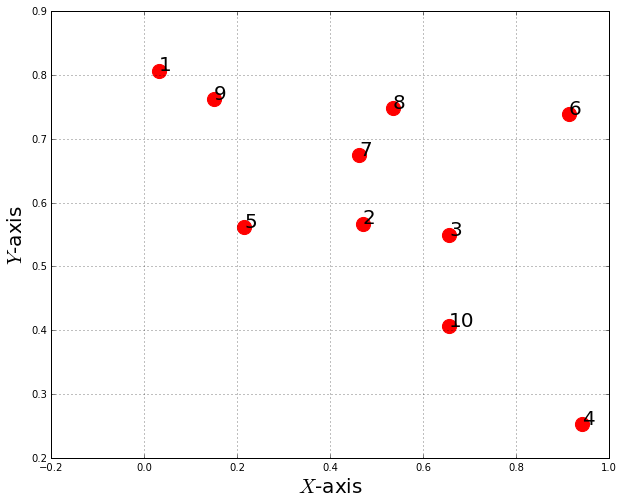

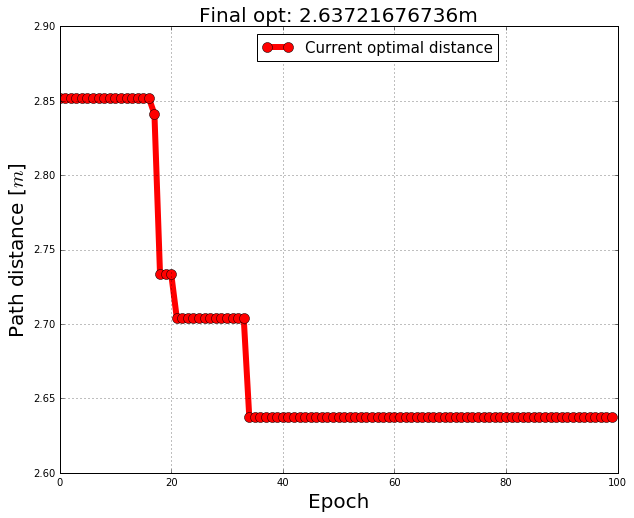

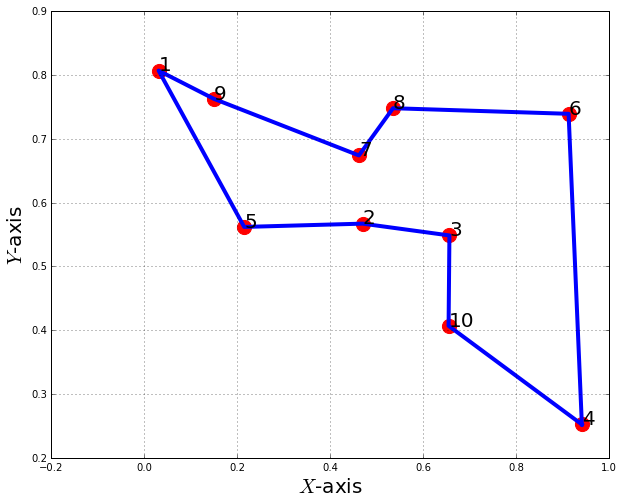

In [6]:
demonstration0()


**总结1**：根据上述仿真实验结果和之前报告中的结果对比，可以明显看出，采用遗传算法求解规模为10的TSP问题，其所得到的解非常接近最优解，而之前报告中采用Hopfield神经网络求解同等规模的TSP问题，得到的路径和最优解有相当差距。而且，采用Hopfield神经网络求解TSP问题的效果受到参数设置的影响非常大(如之前报告指出，Hopfield神经网络求解约束最优化问题时，所涉及的能量函数关于惩罚参数的灵敏性非常高)，而在遗传算法中，一旦给定问题条件及遗传操作规则，算法本身涉及的参数比较少，主要包括：变异概率、交叉概率、总群规模、进化代数，这些参数相对Hopfield神经网络的参数而言，调试起来比较简单。

## 实验2

为了进一步研究不同种群规模对求解TSP效果的影响，本报告给定一个规模为50的TSP问题，每一个城市的位置在$[0,1000]\times[0,1000]$的区域均有随机生成，其中，分别将遗传算法种群规模设置为：50、100、150和200进行测试，其他算法参数保持一致(具体详见上述代码)。得到实验结果如下所示。

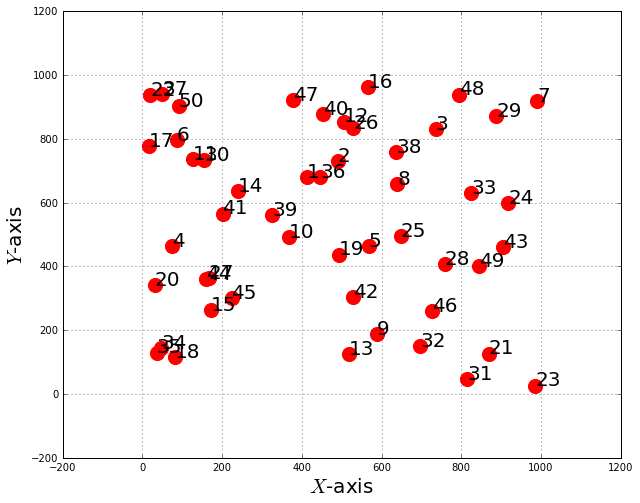

Complete simulation with 50
Complete simulation with 100
Complete simulation with 150
Complete simulation with 200


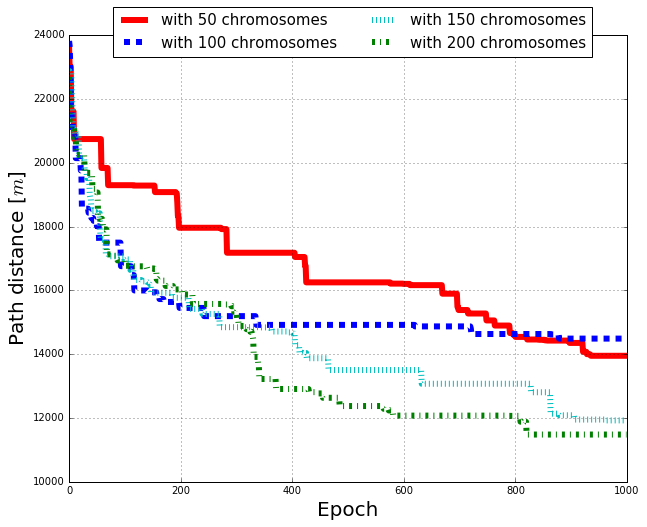

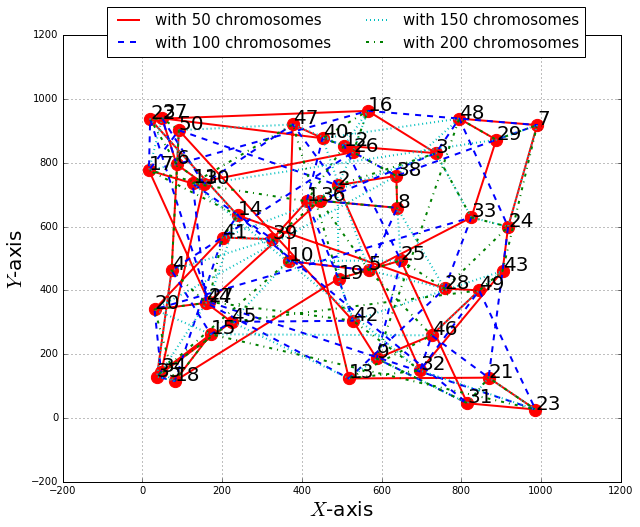

In [8]:
demonstration1()

**总结2**: 从上述实验结果可知，当种群数目比较大，算法比较容易得到更好的解（虽然在本次实验中，种群规模为50的效果优于种群规模为100的效果），而且，迭代前期，例如在迭代次数为0~200之间，种群规模较大则算法优化目标函数值的速度较快——亦即，目标函数值的改进量比较明显。

## 实验3

进一步，本报告研究基因变异概率的设置对遗传算法求解TSP效果的影响。为此，分别设置基因型个体变异率为：0.01、0.05、0.1、0.5，同样设置TSP问题的规模为50，其他参数保持一致(详见源代码)，得到如下实验结果。

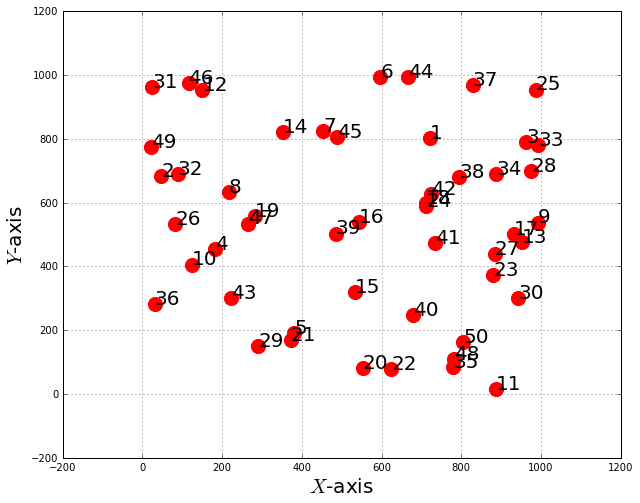

Complete simulation with 0.01
Complete simulation with 0.05
Complete simulation with 0.1
Complete simulation with 0.5


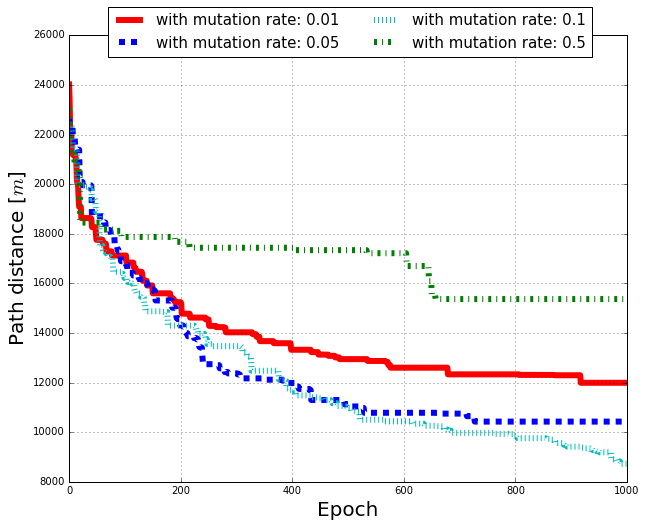

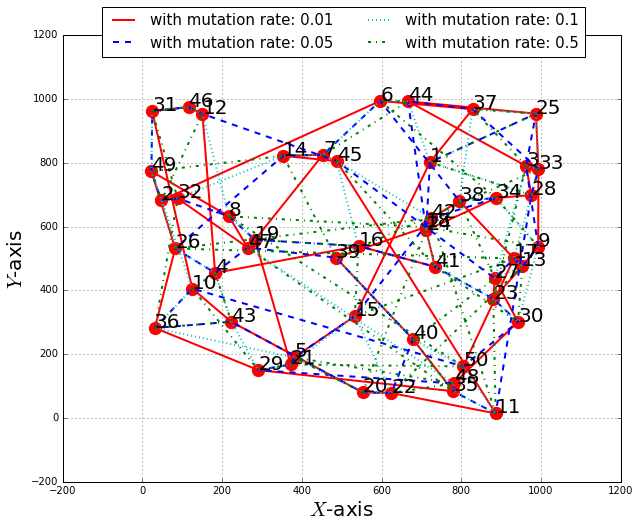

In [9]:
demonstration2()


**总结3**：从上述结果可见，线性增加基因型个体变异概率并不意味着能够增加遗传算法在求解TSP问题中的效果，在给定其他参数情况下，存在一个最优的变异概率。在本报告中，0.1的变异概率“似乎”能够使遗传算法在求解50规模的TSP问题获得较好的效果。

## 参考文献
1. <span id = "ref1"> Grefenstette, J. J., Gopal, R., Rosmaita, B. J., & Gucht, D. V. (1985). [Genetic 
Algorithms for the Traveling Salesman Problem](http://www.cs.indiana.edu/~vgucht/Genetic_Algorithms_for_the_Travelling_Salesman%2BProblem.pdf). 
International Conference on Genetic Algorithms (Vol.63, pp.160-168). </span>